<a href="https://colab.research.google.com/github/bogdanpetrovsky/PINN/blob/main/NN_2025_05_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

# Завантаження CSV
df = pd.read_csv("Results.csv")
df.columns = df.columns.str.strip()

Epoch 0, Loss: 0.107963
Epoch 100, Loss: 0.005057
Epoch 200, Loss: 0.004891
Epoch 300, Loss: 0.004671
Epoch 400, Loss: 0.004300
Epoch 500, Loss: 0.003751
Epoch 600, Loss: 0.003412
Epoch 700, Loss: 0.003354
Epoch 800, Loss: 0.003219
Epoch 900, Loss: 0.003167


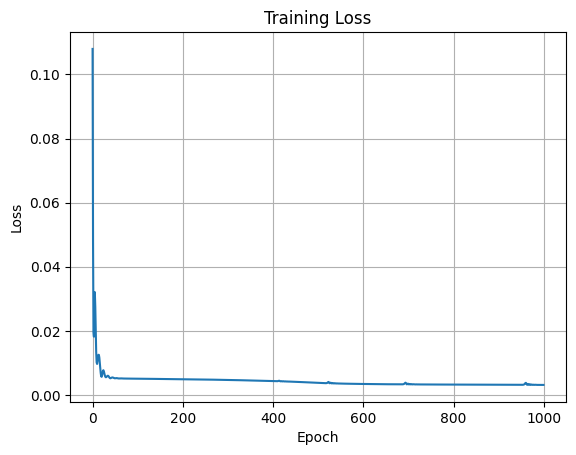

🔍 Real: [2.4882002e-02 2.0500520e+08 2.8390000e-02], Predicted: [ 2.3335652e-02  2.0133784e+08 -1.0666081e+02]
🔍 Real: [2.2697000e-02 1.9824469e+08 2.4323000e-02], Predicted: [2.2796778e-02 2.0110373e+08 1.9730696e+02]
🔍 Real: [5.0808001e-02 2.1040566e+08 3.6366001e-02], Predicted: [5.0856054e-02 2.0947766e+08 1.5728624e+03]
🔍 Real: [2.0435000e-02 1.9653614e+08 2.0761000e-02], Predicted: [ 2.0228613e-02  1.9743730e+08 -6.1803841e+01]
🔍 Real: [4.4427000e-02 1.9855547e+08 2.4419000e-02], Predicted: [4.4574432e-02 1.9949706e+08 1.2669900e+03]


In [ ]:
# Вхідні та вихідні ознаки
X = df[['Thickness', 'Max_punch_displacement', 'Youngs_modulus']]
Y = df[['MaxPlasticStrain', 'MaxVonMises', 'MaxDisp']]

# Масштабування
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# Розділення
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=42)

# Перетворення в тензори
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Нейронна мережа (глибока)
class DeepNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.layers(x)

# Модель, оптимізатор, функція втрат
model = DeepNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Тренування
losses = []
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Побудова графіку втрат
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Оцінка на тесті
model.eval()
pred = model(X_test).detach().numpy()
true = y_test.numpy()

# Зворотне масштабування
pred_orig = scaler_Y.inverse_transform(pred)
true_orig = scaler_Y.inverse_transform(true)

# Порівняння
for i in range(5):
    print(f"🔍 Real: {true_orig[i]}, Predicted: {pred_orig[i]}")

In [ ]:
data = pd.read_csv("Results.csv")
data.columns = data.columns.str.strip()
X = data[['Thickness', 'Max_punch_displacement', 'Youngs_modulus']].values
# Вихід (реакція системи)
y = data[['MaxPlasticStrain', 'MaxVonMises', 'MaxDisp', 'End_angle', 'Residual_angle']].values

# Масштабування
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 2. Побудова моделі
def build_model():
    inputs = tf.keras.Input(shape=(3,))
    x = tf.keras.layers.Dense(128, activation='tanh')(inputs)
    x = tf.keras.layers.Dense(128, activation='tanh')(x)
    x = tf.keras.layers.Dense(128, activation='tanh')(x)
    outputs = tf.keras.layers.Dense(5)(x)
    model = tf.keras.Model(inputs, outputs)
    return model

model = build_model()

# 3. Physics-informed loss
# Наприклад, формулюємо просту втрату на основі закону Гука як перевірку:
# σ = E * ε → перевіримо чи виконується ця пропорція між Young's modulus, MaxPlasticStrain і MaxVonMises

def physics_informed_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # Відновлюємо фізичні параметри (розмасштабовані)
    y_pred_phys = scaler_y.inverse_transform(y_pred)
    strain = y_pred_phys[:, 0]  # MaxPlasticStrain
    stress = y_pred_phys[:, 1]  # MaxVonMises
    disp = y_pred_phys[:, 2]    # MaxDisp

    # Відновимо E з X
    X_inv = scaler_X.inverse_transform(model.input)
    E_modulus = X_inv[:, 2]

    # Гук: σ ≈ E * ε  → перевірка, наскільки виконується ця умова
    stress_pred = E_modulus * strain
    physics_loss = tf.reduce_mean(tf.square(stress - stress_pred))

    return mse_loss + 0.1 * physics_loss  # вагу можна тюнити

# 4. Компіляція та тренування
model.compile(optimizer='adam', loss=physics_informed_loss)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=32)

# Збереження
model.save("pinn_deformation_model.h5")

Epoch 1/500


NotImplementedError: Cannot convert a symbolic tf.Tensor (functional_1/dense_3_1/BiasAdd:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Завантаження даних
data = pd.read_csv("Results.csv")
data.columns = data.columns.str.strip()

# Вхідні параметри
X = data[['Thickness', 'Max_punch_displacement', 'Youngs_modulus']].values.astype(np.float32)
# Вихід
y = data[['MaxPlasticStrain', 'MaxVonMises', 'MaxDisp']].values.astype(np.float32)

# Масштабування
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X).astype(np.float32)
y_scaled = scaler_y.fit_transform(y).astype(np.float32)

# Тренувальний розподіл
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 2. Побудова моделі
def build_model():
    inputs = tf.keras.Input(shape=(3,))
    x = tf.keras.layers.Dense(128, activation='tanh')(inputs)
    x = tf.keras.layers.Dense(128, activation='tanh')(x)
    x = tf.keras.layers.Dense(128, activation='tanh')(x)
    outputs = tf.keras.layers.Dense(3)(x)
    return tf.keras.Model(inputs, outputs)

model = build_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# 3. Кастомний train step з physics loss
@tf.function
def train_step(x_batch, y_batch):
    with tf.GradientTape() as tape:
        y_pred = model(x_batch, training=True)
        mse_loss = tf.reduce_mean(tf.square(y_batch - y_pred))

        # Inverse scaling для y
        y_pred_phys = y_pred * tf.constant(scaler_y.scale_, dtype=tf.float32) + tf.constant(scaler_y.mean_, dtype=tf.float32)
        strain = y_pred_phys[:, 0]  # MaxPlasticStrain
        stress = y_pred_phys[:, 1]  # MaxVonMises

        # Inverse scaling для X
        x_inv = x_batch * tf.constant(scaler_X.scale_, dtype=tf.float32) + tf.constant(scaler_X.mean_, dtype=tf.float32)
        E_modulus = x_inv[:, 2]

        # Кліп значення E, щоб уникнути переповнення
        E_modulus = tf.clip_by_value(E_modulus, 1e6, 3e11)

        # Physics loss: σ ≈ E·ε
        stress_pred = E_modulus * strain
        physics_loss = tf.reduce_mean(tf.square(stress - stress_pred))

        total_loss = mse_loss + 0.1 * physics_loss
        total_loss = tf.where(tf.math.is_nan(total_loss), tf.constant(0.0, dtype=tf.float32), total_loss)

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss

# 4. Навчання
EPOCHS = 300
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for step, (x_batch, y_batch) in enumerate(train_dataset):
        loss = train_step(x_batch, y_batch)
        epoch_loss += loss

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {epoch_loss.numpy():.4f}")

# 5. Збереження моделі
model.save("pinn_deformation_model.h5")


Epoch 0, Loss: 142694799441395712.0000
Epoch 50, Loss: 51393122304.0000
Epoch 100, Loss: 30355322880.0000
Epoch 150, Loss: 17281243136.0000
Epoch 200, Loss: 908106.2500
Epoch 250, Loss: 19514705920.0000


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Завантаження даних
data = pd.read_csv("Results (1).csv")
data.columns = data.columns.str.strip()

# Прибираємо рядки з пропущеними значеннями
data = data.dropna()

# Вхідні параметри
X_raw = data[['Thickness', 'Max_punch_displacement', 'Youngs_modulus']].values
y_raw = data[['MaxPlasticStrain', 'MaxVonMises', 'MaxDisp']].values  # без кутів

# Масштабування
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# Розділення на train/val
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 2. Побудова моделі
def build_model():
    inputs = tf.keras.Input(shape=(3,))
    x = tf.keras.layers.Dense(64, activation='tanh')(inputs)
    x = tf.keras.layers.Dense(64, activation='tanh')(x)
    outputs = tf.keras.layers.Dense(3)(x)
    return tf.keras.Model(inputs, outputs)

model = build_model()

# 3. Стандартне переднавчання (без physics)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse')
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, batch_size=32)

# 4. Оголошення фізично-інформованого навчання
lambda_phy = 0.01  # коефіцієнт фізичних втрат

# Перетворення на float32 (TensorFlow очікує саме float32)
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

# Перехід на низькорівневе навчання з physics loss
optimizer = tf.keras.optimizers.Adam(1e-4)
batch_size = 32
epochs = 300

for epoch in range(epochs):
    idx = np.random.permutation(len(X_train))
    X_train = X_train[idx]
    y_train = y_train[idx]

    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            mse_loss = tf.reduce_mean(tf.square(y_batch - y_pred))

            # Розмасштабуємо
            y_pred_phys = scaler_y.inverse_transform(y_pred.numpy())
            strain = y_pred_phys[:, 0]  # MaxPlasticStrain
            stress = y_pred_phys[:, 1]  # MaxVonMises

            # Відновлюємо Young's modulus
            X_inv = scaler_X.inverse_transform(X_batch.numpy())
            E = X_inv[:, 2]

            # Нормалізація перед physics loss
            strain_norm = (strain - np.mean(strain)) / (np.std(strain) + 1e-8)
            stress_norm = (stress - np.mean(stress)) / (np.std(stress) + 1e-8)
            E_norm = (E - np.mean(E)) / (np.std(E) + 1e-8)

            stress_pred = E_norm * strain_norm
            physics_loss = np.mean((stress_norm - stress_pred) ** 2)

            total_loss = mse_loss + lambda_phy * physics_loss

        grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % 50 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch}, MSE: {mse_loss.numpy():.4f}, Physics: {physics_loss:.4f}, Total: {total_loss.numpy():.4f}")

# Збереження моделі
model.save("pinn_deformation_model_v2.h5")

Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.6964 - val_loss: 0.2685
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.5168 - val_loss: 0.2226
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.5354 - val_loss: 0.2202
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.5256 - val_loss: 0.2193
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.2812 - val_loss: 0.2199
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3235 - val_loss: 0.2191
Epoch 7/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2835 - val_loss: 0.2187
Epoch 8/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3468 - val_loss: 0.2179
Epoch 9/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2633 - val_loss: 0.2173
Epoch 10/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5093 - val_loss: 0.2162
Epoch 11/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6321 - val_loss: 0.2155
Epoch 12/300
144/144 ━━━━━━━━━━━

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Завантаження та підготовка даних
data = pd.read_csv("Results (1).csv")
data.columns = data.columns.str.strip()
data = data.dropna()

X_raw = data[['Thickness', 'Max_punch_displacement', 'Youngs_modulus']].values.astype(np.float32)
y_raw = data[['MaxPlasticStrain', 'MaxVonMises', 'MaxDisp']].values.astype(np.float32)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 2. Побудова моделі
def build_model():
    inputs = tf.keras.Input(shape=(3,))
    x = tf.keras.layers.Dense(128, activation='tanh')(inputs)
    x = tf.keras.layers.Dense(128, activation='tanh')(x)
    x = tf.keras.layers.Dense(128, activation='tanh')(x)
    outputs = tf.keras.layers.Dense(3)(x)
    return tf.keras.Model(inputs, outputs)

model = build_model()

# 3. Переднавчання
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32, verbose=0)

# 4. Physics-Informed навчання
lambda_phy = 0.1
optimizer = tf.keras.optimizers.Adam(1e-4)
epochs = 300
batch_size = 32

for epoch in range(epochs):
    idx = np.random.permutation(len(X_train))
    X_train, y_train = X_train[idx], y_train[idx]
    total_loss_epoch = []

    for i in range(0, len(X_train), batch_size):
        X_batch = tf.convert_to_tensor(X_train[i:i+batch_size])
        y_batch = tf.convert_to_tensor(y_train[i:i+batch_size])

        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            mse_loss = tf.reduce_mean(tf.square(y_batch - y_pred))

            y_pred_np = y_pred.numpy()
            y_pred_phys = scaler_y.inverse_transform(y_pred_np)
            strain = y_pred_phys[:, 0]
            stress = y_pred_phys[:, 1]

            X_inv = scaler_X.inverse_transform(X_batch.numpy())
            E = X_inv[:, 2]

            stress_pred = E * strain
            physics_loss = np.mean(((stress - stress_pred) / (stress + 1e-6)) ** 2)

            total_loss = mse_loss + lambda_phy * physics_loss

        grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        total_loss_epoch.append(total_loss.numpy())

    if epoch % 50 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch}, MSE: {mse_loss.numpy():.6f}, Physics: {physics_loss:.6f}, Total: {np.mean(total_loss_epoch):.6f}")

# 5. Збереження моделі
model.save("pinn_deformation_model.keras")

# 6. Тестовий приклад
example = np.array([[1.5, 5.0, 210000]])
example_scaled = scaler_X.transform(example)
prediction_scaled = model.predict(example_scaled)
prediction = scaler_y.inverse_transform(prediction_scaled)

print("\n🧪 Перевірка:")
print(f"Вхід: товщина = 1.5 мм, зміщення = 5.0 мм, E = 210000 МПа")
print(f"→ Прогнозована деформація (MaxPlasticStrain): {prediction[0,0]:.6f}")
print(f"→ Прогнозоване напруження (MaxVonMises):     {prediction[0,1]:.2f} МПа")
print(f"→ Прогнозоване зміщення (MaxDisp):           {prediction[0,2]:.4f} мм")

Epoch 0, MSE: 0.107652, Physics: 1.000000, Total: 0.507674
Epoch 50, MSE: 0.202383, Physics: 1.000000, Total: 0.460537
Epoch 100, MSE: 0.098756, Physics: 1.000000, Total: 0.426115
Epoch 150, MSE: 0.033200, Physics: 1.000000, Total: 0.386099
Epoch 200, MSE: 0.075806, Physics: 1.000000, Total: 0.349420
Epoch 250, MSE: 0.054027, Physics: 1.000000, Total: 0.307461
Epoch 299, MSE: 0.060569, Physics: 1.000000, Total: 0.273120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

🧪 Перевірка:
Вхід: товщина = 1.5 мм, зміщення = 5.0 мм, E = 210000 МПа
→ Прогнозована деформація (MaxPlasticStrain): 0.048560
→ Прогнозоване напруження (MaxVonMises):     212367632.00 МПа
→ Прогнозоване зміщення (MaxDisp):           2347.8931 мм


In [ ]:
example1 = np.array([[0.55, 18.6, 71.5]])
example_scaled1 = scaler_X.transform(example1)
prediction_scaled1 = model.predict(example_scaled1)
prediction1 = scaler_y.inverse_transform(prediction_scaled1)

print("\n🧪 Перевірка:")
print(f"Вхід: товщина = 1.5 мм, зміщення = 5.0 мм, E = 210000 МПа")
print(f"→ Прогнозована деформація (MaxPlasticStrain): {prediction1[0,0]:.6f}")
print(f"→ Прогнозоване напруження (MaxVonMises):     {prediction1[0,1]:.6f} МПа")
print(f"→ Прогнозоване зміщення (MaxDisp):           {prediction1[0,2]:.6f} мм")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

🧪 Перевірка:
Вхід: товщина = 1.5 мм, зміщення = 5.0 мм, E = 210000 МПа
→ Прогнозована деформація (MaxPlasticStrain): 0.015290
→ Прогнозоване напруження (MaxVonMises):     200255216.000000 МПа
→ Прогнозоване зміщення (MaxDisp):           -235.026428 мм


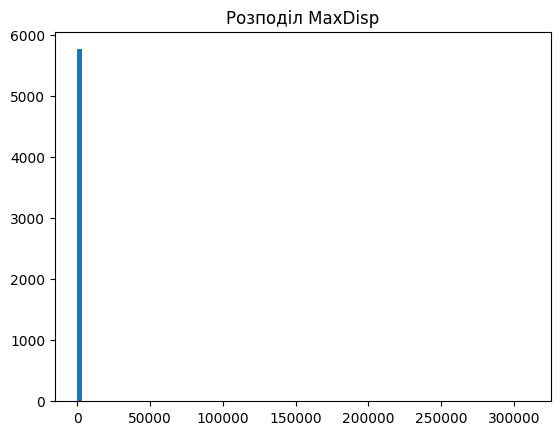

Epoch 0, MSE: 0.475912, Physics: 1.000000, Total: 4.699279
Epoch 50, MSE: 0.816220, Physics: 1.000000, Total: 4.659496
Epoch 100, MSE: 0.720710, Physics: 1.000000, Total: 4.638310
Epoch 150, MSE: 0.501261, Physics: 1.000000, Total: 4.610876
Epoch 200, MSE: 0.372912, Physics: 1.000000, Total: 4.596482
Epoch 250, MSE: 0.536421, Physics: 1.000000, Total: 4.567585
Epoch 299, MSE: 0.470779, Physics: 1.000000, Total: 4.553410
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step

🧪 Перевірка (реальні значення):
Очікувано:  0.015199 | 199349210.442306 | 0.020338
Прогноз NN:
0.040052
198257600.000000
166.661026


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Завантаження та підготовка даних
data = pd.read_csv("Results (1).csv")
data.columns = data.columns.str.strip()
data = data.dropna()

# Перевіримо розподіл MaxDisp
plt.hist(data["MaxDisp"], bins=100)
plt.title("Розподіл MaxDisp")
plt.show()

X_raw = data[['Thickness', 'Max_punch_displacement', 'Youngs_modulus']].values.astype(np.float32)
y_raw = data[['MaxPlasticStrain', 'MaxVonMises', 'MaxDisp']].values.astype(np.float32)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 2. Побудова моделі з нормалізацією та регуляризацією
def build_model():
    inputs = tf.keras.Input(shape=(3,))
    x = tf.keras.layers.LayerNormalization()(inputs)
    x = tf.keras.layers.Dense(128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = tf.keras.layers.Dense(128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = tf.keras.layers.Dense(128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    outputs = tf.keras.layers.Dense(3)(x)
    return tf.keras.Model(inputs, outputs)

model = build_model()

# 3. Попереднє навчання зі зваженою MSE
def weighted_mse(y_true, y_pred):
    weights = tf.constant([1.0, 1.0, 10.0], dtype=tf.float32)
    return tf.reduce_mean(weights * tf.square(y_true - y_pred))

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=weighted_mse)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32, verbose=0)

# 4. Physics-Informed навчання
lambda_phy = 0.1
optimizer = tf.keras.optimizers.Adam(1e-4)
epochs = 300
batch_size = 32

for epoch in range(epochs):
    idx = np.random.permutation(len(X_train))
    X_train, y_train = X_train[idx], y_train[idx]
    total_loss_epoch = []

    for i in range(0, len(X_train), batch_size):
        X_batch = tf.convert_to_tensor(X_train[i:i+batch_size])
        y_batch = tf.convert_to_tensor(y_train[i:i+batch_size])

        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            mse_loss = weighted_mse(y_batch, y_pred)

            y_pred_np = y_pred.numpy()
            y_pred_phys = scaler_y.inverse_transform(y_pred_np)
            strain = y_pred_phys[:, 0]
            stress = y_pred_phys[:, 1]

            X_inv = scaler_X.inverse_transform(X_batch.numpy())
            E = X_inv[:, 2]

            stress_pred = E * strain
            physics_loss = np.mean(((stress - stress_pred) / (stress + 1e-6)) ** 2)

            total_loss = mse_loss + lambda_phy * physics_loss

        grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        total_loss_epoch.append(total_loss.numpy())

    if epoch % 50 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch}, MSE: {mse_loss.numpy():.6f}, Physics: {physics_loss:.6f}, Total: {np.mean(total_loss_epoch):.6f}")

# 5. Збереження моделі
model.save("pinn_deformation_model.keras")

# 6. Тестовий приклад
example = np.array([[0.55, 18.6, 71.5]])  # приклад з датасету
example_scaled = scaler_X.transform(example)
prediction_scaled = model.predict(example_scaled)
prediction = scaler_y.inverse_transform(prediction_scaled)

print("\n🧪 Перевірка (реальні значення):")
print("Очікувано:  0.015199 | 199349210.442306 | 0.020338")
print("Прогноз NN:")
print(f"{prediction[0,0]:.6f}")  # MaxPlasticStrain
print(f"{prediction[0,1]:.6f}")  # MaxVonMises
print(f"{prediction[0,2]:.6f}")  # MaxDisp

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Завантаження даних
data = pd.read_csv("Results (1).csv")
data.columns = data.columns.str.strip()
data = data.dropna()

X_raw = data[['Thickness', 'Max_punch_displacement', 'Youngs_modulus']].values.astype(np.float32)
y_raw = data[['MaxPlasticStrain', 'MaxVonMises', 'MaxDisp']].values.astype(np.float32)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 2. Побудова моделі
def build_model():
    inputs = tf.keras.Input(shape=(3,))
    x = tf.keras.layers.Dense(128, activation='tanh')(inputs)
    x = tf.keras.layers.Dense(128, activation='tanh')(x)
    x = tf.keras.layers.Dense(128, activation='tanh')(x)
    outputs = tf.keras.layers.Dense(3)(x)
    return tf.keras.Model(inputs, outputs)

model = build_model()

# 3. Переднавчання (емпіричне)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32, verbose=0)

# 4. Physics-Informed навчання (з вагами для MSE)
lambda_phy = 0.1
optimizer = tf.keras.optimizers.Adam(1e-4)
epochs = 300
batch_size = 32

# Ваги для кожного з виходів: [MaxPlasticStrain, MaxVonMises, MaxDisp]
weights = tf.constant([5.0, 1.0, 10.0], dtype=tf.float32)

for epoch in range(epochs):
    idx = np.random.permutation(len(X_train))
    X_train, y_train = X_train[idx], y_train[idx]
    total_loss_epoch = []

    for i in range(0, len(X_train), batch_size):
        X_batch = tf.convert_to_tensor(X_train[i:i+batch_size])
        y_batch = tf.convert_to_tensor(y_train[i:i+batch_size])

        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)

            # Зважений MSE
            weighted_errors = tf.square(y_batch - y_pred) * weights
            mse_loss = tf.reduce_mean(tf.reduce_sum(weighted_errors, axis=1))

            # Physics loss
            y_pred_np = y_pred.numpy()
            y_pred_phys = scaler_y.inverse_transform(y_pred_np)
            strain = y_pred_phys[:, 0]
            stress = y_pred_phys[:, 1]

            X_inv = scaler_X.inverse_transform(X_batch.numpy())
            E = X_inv[:, 2]

            stress_pred = E * strain
            physics_loss = np.mean(((stress - stress_pred) / (stress + 1e-6)) ** 2)

            total_loss = mse_loss + lambda_phy * physics_loss

        grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        total_loss_epoch.append(total_loss.numpy())

    if epoch % 50 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch}, MSE: {mse_loss.numpy():.6f}, Physics: {physics_loss:.6f}, Total: {np.mean(total_loss_epoch):.6f}")

# 5. Збереження моделі
model.save("pinn_deformation_model_fixed.keras")

# 6. Тестовий приклад
example1 = np.array([[0.55, 18.6, 71.5]])
example_scaled1 = scaler_X.transform(example1)
prediction_scaled1 = model.predict(example_scaled1)
prediction1 = scaler_y.inverse_transform(prediction_scaled1)

print("\n🧪 Перевірка (реальні значення):")
print("Очікувано:  0.015199 | 199349210.442306 | 0.020338")
print("Прогноз NN:")
print(f"{prediction1[0,0]:.6f}")
print(f"{prediction1[0,1]:.6f}")
print(f"{prediction1[0,2]:.6f}")

Epoch 0, MSE: 0.539952, Physics: 1.000000, Total: 11.085417
Epoch 50, MSE: 0.217777, Physics: 1.000000, Total: 8.478932
Epoch 100, MSE: 0.283364, Physics: 1.000000, Total: 7.347523
Epoch 150, MSE: 0.139300, Physics: 1.000000, Total: 6.060500
Epoch 200, MSE: 0.186701, Physics: 1.000000, Total: 4.789543
Epoch 250, MSE: 0.445787, Physics: 1.000000, Total: 3.657020
Epoch 299, MSE: 0.493829, Physics: 1.000000, Total: 2.716455
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step

🧪 Перевірка (реальні значення):
Очікувано:  0.015199 | 199349210.442306 | 0.020338
Прогноз NN:
0.015258
199096496.000000
-27.170897


clear
close all
clc
format long
tic
// Initialize COMSOL Model
import com.comsol.model.*
import com.comsol.model.util.*

// Load the COMSOL Model
model = mphopen('C:\Users\bpetr\Desktop\Metal_shape_forming.mph');

// mphgetexpressions(model, 'param')

%param_range=[1e-4 2e-2:2e-2:1.5];
% Parameter settings

N=14; % N^3 amount of points for NN

% sigma0_values = linspace(190,212,23); % Range of sigma_0 (yield stress) values
thickness_values=linspace(0.45,1.45,N);
punch_max_values=linspace(18,28,N);
You_m_values=linspace(75.5,175.5,N);
% Pr_values=linspace(0.25,0.35,11);
output_file = 'Results.csv'; % File to save the results



fid = fopen(output_file, 'w');
fprintf(fid, 'Thickness, Max_punch_displacement, Youngs_modulus, MaxPlasticStrain, MaxVonMises, MaxDisp, End_angle, Residual_angle\n');

% model.study('std1').create('param', 'Parametric');
% model.study('std1').feature('param').set('pname', {'param'}); % Parameter name
% model.study('std1').feature('param').set('plist', num2str(param_range))
k=1;
for thickness=thickness_values
   for punch_max=punch_max_values
       for i1=1:length(You_m_values)

        
   
    th=num2str(thickness)+"[mm]";
    You_m=You_m_values(i1);
    model.param.set('th',th);
    model.param.set('punch_max', num2str(punch_max));
    model.param.set('You_m', num2str(You_m));
    

   % model.param.set('Pr', num2str(Pr));
    % Run the simulation
    try
    model.study('std1').run();
    
    pd1 = mphplot(model,'pg1','rangenum',1);
    my_plot1='my_plot1_';
    idx=num2str(k);
    C1={my_plot1,idx,'.png'};
    saveas(gcf, strjoin(C1,''));
    pd2 = mphplot(model,'pg2','rangenum',1);
    my_plot2='my_plot2_';
    C2={my_plot2,idx,'.png'};
    saveas(gcf, strjoin(C2,''));
    pd3 = mphplot(model,'pg3','rangenum',1);
    my_plot3='my_plot3_';
    C3={my_plot3,idx,'.png'};
    saveas(gcf, strjoin(C3,''));
    k=k+1;
    close all
    % Extract  the results
  %  model.result.table.tags()
    str = mphtable(model,'tbl3');
    tbl_data = str.data;
    min_angle=min(tbl_data(:,2));
    end_angle=tbl_data(end,2);
    residual_angle=end_angle-min_angle;

     % model.result.tags()
%     para_range=tbl_data(:,1);
%     fig=mphplot(model,'pg3','createplot','off');
    max_plastic_strain=mphmax(model, 'solid.epe','surface', 'dataset', 'dset1','solnum', 'end');
    max_Mises_stress=mphmax(model, 'solid.mises','surface', 'dataset', 'dset1','solnum', 'end');
    max_Displacement=mphmax(model, 'solid.disp','surface', 'dataset', 'dset1','solnum', 'end');
    catch
        continue
    end
    tableObj = model.result.table('tbl3');
    tableObj.feature().clear();

    % Write data to the file
                                                                                                        
    fprintf(fid, '%f, %f, %f, %f, %f, %f, %f, %f\n', thickness,punch_max,You_m, max_plastic_strain, max_Mises_stress, max_Displacement,end_angle,residual_angle);
    fprintf('Processed Thickness = %f mm, punch_max = %f, You_m = %f, max_plastic_strain = %f, max_Mises_stress = %f,max_Displacement = %f,End_angle = %f,Residual_angle = %f\n',...
        thickness,punch_max,You_m, max_plastic_strain, max_Mises_stress,max_Displacement,end_angle,residual_angle);

        end
    end
end

% save model
mphsave(model,'C:\Users\bpetr\Desktop\\Metal_shape_forming.mph')

% Close the file
fclose(fid);

disp('Simulation complete. Results saved to Results.csv.');
toc